# <span style="color:red">  **SIMULATIONS ET MÉTHODES DE MONTE CARLO**  </span>

In [1]:
import numpy as np 
from scipy.stats import multivariate_normal
import Estimateurs
import Code
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Sommaire

- [Partie 0. Définition du cadre gaussien pour la génération des données](#partie-0-définition-du-cadre-gaussien-pour-la-génération-des-données)
  - [0.1. Génération du vrai $\theta$](#01-génération-du-vrai-theta)
  
  - [0.2. Génération de notre vecteur d'observation $\boldsymbol{x} \in \mathbb{R}^{20}$](#02-génération-de-notre-vecteur-dobservation-boldsymbolx-in-mathbbr20)

  - [0.3. Génération de la vraie log-vraisemblance et du vrai gradient associé à $\theta_{\text{true}}$ et à notre observation $\boldsymbol{x}$](#03-génération-de-la-vraie-log-vraisemblance-et-du-vrai-gradient-associé-à-thetatru-et-à-notre-observation-boldsymbolx)

  - [0.4. Génération des paramètres de l'encodeur $A \in \mathbb{R}^{20\times 20}$ et $b \in \mathbb{R}^{20}$](#04-génération-des-paramètres-de-lencodeur-a-in-mathbbr2020-et-b-in-mathbbr20)

- [Partie 1. Comparaison des estimateurs de la vraisemblance du modèle](#partie-1-comparaison-des-estimateurs-de-la-vraisemblance-du-modèle)

  - [1.1 Les estimateurs RR (Roulette Russe) et SS (Single Sample)](#11-les-estimateurs-rr-roulette-russe-et-ss-single-sample)

    - [1.1.1 Estimateur ML-SS](#111-estimateur-ml-ss)

    - [1.1.2 Estimateur ML-RR](#112-estimateur-ml-rr)
    
  - [1.2 L'estimateurs SUMO (Stochastically Unbiased Marginalization Objective (SUMO))](#12-lestimateurs-sumo-stochastically-unbiased-marginalization-objective-sumo)

  - [1.3 L'estimateurs IWAE (Autoencoder Pondéré par l'Importance)](#13-lestimateurs-iwae-autoencoder-pondéré-par-limportance)
  
  - [1.4 Comparaison entre les différents estimateurs](#14-comparaison-entre-les-différents-estimateurs)

<span style="color:blue">  **NOTATIONS**  </span> : on se donne un ensemble de données $\boldsymbol{x} = \{x^{(i)}\}_{i=1}^n$ composé de $n$ échantillons i.i.d. d'une variable continue ou discrète $x$ à valeurs dans un espace d'observations $\boldsymbol{\mathcal{X}}$ (ainsi $\boldsymbol{x} \in \boldsymbol{\mathcal{X}}$). Nous supposons que les données sont générées par un processus aléatoire impliquant une variable aléatoire continue non observée $\boldsymbol{z} = \{z^{(i)}\}_{i=1}^n$ à valeur dans un espace d'observations $\boldsymbol{\mathcal{Z}}$ (ainsi $\boldsymbol{z} \in \boldsymbol{\mathcal{Z}}$). Le processus se compose de deux étapes :


1. La valeur $z^{(i)}$ est générée à partir d'une distribution a priori $p_{\theta^*}(z)$ ;
2. Une valeur $x^{(i)}$ est générée à partir d'une distribution conditionnelle $p_{\theta^*}(x|z)$.


Nous supposons que la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ proviennent de familles paramétriques de distributions $p_{\theta}(\boldsymbol{z})$ et $p_{\theta}(\boldsymbol{x}|\boldsymbol{z})$ et on note $\Theta \subset \mathbb{R}^d$ l'espace des paramètres. On connait ainsi l'expression de ces deux distributions. En revanche une grande partie de ce processus nous est cachée : les véritables paramètres $\theta^*$ ainsi que les valeurs des $\textbf{variables latentes}$ $z^{(i)}$ nous sont inconnus. 

Connaissant l'expression de la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ pour tout $\theta \in \Theta$, on peut définir la densité jointe $p_{\theta}(\boldsymbol{x}, \boldsymbol{z})$ sur $\boldsymbol{\mathcal{X}} \times \boldsymbol{\mathcal{Z}}$ par : 

$$
p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = p_{\theta}(\boldsymbol{x}|\boldsymbol{z}) p_{\theta}(\boldsymbol{z})
$$

<span style="color:blue">  **OBJECTIF**  </span> : on cherche à déterminer la vraie valeur du paramètre (ici $\theta^*$) ainsi que les valeurs des variables latentes. 

Une approche classique pour apprendre $\boldsymbol{\theta}$ est de choisir, si celle-ci existe, la valeur de ce paramètre qui maximise la log-vraisemblance marginale de l’ ́echantillon définie par :

$$
\ell(\boldsymbol{\theta}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \log \int_{\boldsymbol{\mathcal{Z}}} p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}) d\boldsymbol{z}
$$

<span style="color:blue">  **PROBLÈME**  </span> : l'intégrale donnée en ci-dessus est intractable (nous ne pouvons donc pas évaluer ou différencier la vraisemblance marginale).

<span style="color:blue">  **SOLUTION**  </span> : dans le but de résoudre les problèmes ci-dessus, introduisons un **modèle de reconnaissance** (paramétrique) {$ q_{\phi}(\boldsymbol{z}|\boldsymbol{x}) : \phi \in \Phi$} avec $\Phi \subset \mathbb{R}^d$. Pour tout $\phi$, $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$ est choisi comme une approximation de la véritable postérieure intractable $p_{\theta}(\boldsymbol{z}|\boldsymbol{x})$. L'idée est donc de proposer une valeur de l'a posteriori (faire une hypothèse) et d'introduire une méthode pour apprendre les paramètres du **modèle de reconnaissance** $\phi$ conjointement avec les paramètres du **modèle génératif** $\theta$.

## <span style="color:green">  **Partie 0. Définition du cadre gaussien pour la génération des données**  </span>

(Application numérique inspirée de [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf))

- Le **modèle génératif** est donné par $p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = \mathcal{N}(\boldsymbol{z}|\theta, I) \mathcal{N}(\boldsymbol{x}|\boldsymbol{z}, I)$, où $\boldsymbol{x}$ et $\boldsymbol{z} \in \mathbb{R}^{20}$, de sorte que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ et $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$. 

- La **distribution de l'encodeur** (le modèle de reconnaissance) est $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$.

- Nous considérons des perturbations aléatoires des paramètres près de la valeur optimale par une distribution gaussienne de moyenne nulle et d'écart-type $0.01$.

**Dans ce cas, on peut analytiquement calculer la vraie log-vraisemblance du modèle pour quantifier le biais et la variance de tous les estimateurs**.

Puisque $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$ est censé être une approximation de la véritable loi a posteriori donnée par $p_{\boldsymbol{\theta}}(\boldsymbol{z} | \boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$

### <span style="color:orange"> 0.1. **Génération du vrai $\theta$**  </span>

On commence par tirer le $\theta$* ($\in \mathbb{R}$) qui sera le paramètre que l'on cherchera à estimer par la suite. 

A la manière de la génération des données dans [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) : $\theta^* \sim \mathcal{N}(0, 1)$

In [2]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {int(theta_true*100)/100}")

La valeur de theta à estimer est -0.87


### <span style="color:orange"> 0.2. **Génération de notre vecteur d'observation $\boldsymbol{x} \in \mathbb{R}^{20}$**  </span>

L'idée est désormais de tirer une observation $\boldsymbol{x} \in \mathbb{R}^{20}$, chose que l'on peut faire puisque toutes les distributions nous sont données. 


In [3]:
## On se donne notre échantillon x

x, _ = Estimateurs.joint_probability(theta_true)

print(f"L'échantillon x observé est :\n \n x = {x} \n \n et on vérifique bien sa taille est celle voulue : {x.shape}")

L'échantillon x observé est :
 
 x = [-1.57117701 -2.22216066 -3.08570099 -0.3090851  -2.24806268 -2.45166221
 -0.08541014  0.09423956 -1.49845527 -0.69788739 -1.62698775  0.39054569
 -0.62915104 -2.11971633 -3.19868916 -1.55389399 -1.69388039 -2.6764252
 -0.63279671  0.95710966] 
 
 et on vérifique bien sa taille est celle voulue : (20,)


### <span style="color:orange"> 0.3. **Génération de la vraie log-vraisemblance et du vrai gradient associé à $\theta_{\text{true}}$ et à notre observation $\boldsymbol{x}$**  </span>

On rappelle que l'on nous a donné que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ pour tout $\boldsymbol{x} \in \mathbb{R}^{20}$, ainsi, on peut explicitement calculer la log-vraisemblance et du vrai gradient de $p_{\theta}$ par rapport à $\theta$. On a :

\begin{align*}
\ell (\theta) = \log p_{\theta}(\boldsymbol{x}) = \log (\mathcal{N}(\boldsymbol{x}|\theta, 2I)) &= \log \left ( \frac{1}{\sqrt{(2\pi)^{20} \det(2I)}} \exp \left\{-\frac{1}{2} (x-\theta\bm{1}_{20})^T (2I)^{-1} (x-\theta\bm{1}_{20}) \right\} \right )\\
&= \log \left ( \frac{1}{(2\pi)^{10} 2^{10}} \exp \left\{-\frac{1}{4} (x-\theta\bm{1}_{20})^T (x-\theta\bm{1}_{20}) \right\} \right )\\
&= - 10 \log (4\pi) -\frac{1}{4} (x-\theta\bm{1}_{20})^T (x-\theta\bm{1}_{20})\\
&= - 10 \log (4\pi) -\frac{1}{4} \| x - \theta \mathbf{1}_{20} \|^2\\
&= - 10 \log (4\pi) -\frac{1}{4} \sum_{i=1}^{20} (x_i - \theta)^2

\end{align*}

Et, alors 

\begin{align*}
\nabla_{\theta}\ell (\theta) = \ell '(\theta) &= \frac{1}{2} \sum_{i=1}^{20} (x_i - \theta)\\
&= \frac{1}{2} \sum_{i=1}^{20}x_i - 10 \theta \\
&= 10 \frac{1}{20} \sum_{i=1}^{20}x_i - 10 \theta \\
&= 10 (\bar{x}_{20} - \theta)
\end{align*}

In [4]:
true_likelihood = Code.true_likelihood(x, theta_true)
true_gradient = Code.true_grad(x, theta_true)

print(f"La valeur associée à la log-vraisemblance de l'échantillon x pour theta_true est : {true_likelihood} \n ")
print(f"La valeur associée au gradient de l'échantillon x pour theta_true est : \n\n {true_gradient} \n ")

La valeur associée à la log-vraisemblance de l'échantillon x pour theta_true est : -26.453227719538457 
 
La valeur associée au gradient de l'échantillon x pour theta_true est : 

 -4.723331635965731 
 


### <span style="color:orange"> 0.4. **Génération des paramètres de l'encodeur $A \in \mathbb{R}^{20\times 20}$ et $b \in \mathbb{R}^{20}$**  </span>

Il est maintenant question de tirer notre encodeur tel que : $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$. **Le problème qui se pose est donc celui du choix de $A$ et de $b$**. Dans l'article [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), il nous est indiqué : 

*"Following [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), we consider random perturbations of the parameters near the optimal value by a zero-mean Gaussian with standard deviation 0.01"*

Ainsi, étant donné une observation $\boldsymbol{x}$,  le choix parfait pour $\phi$ serait $\phi^* = (A^*, b^*)$ où $A^* = \frac{1}{2}\boldsymbol{I}_{20} \in \mathbb{R}^{20 \times 20}$ et $b^* = [\frac{\theta^*}{2}, ..., \frac{\theta^*}{2}]^T \in \mathbb{R}^{20} $. Suivant l'indication dans l'article, nous nous plaçons dans un cas où on aurait réussi à inférer de manière convenable la loi $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$, mais pas parfaitement. Ainsi,  on introduit de la même façon que dans l'article [[Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) une perturbation autour de la valeur optimale du paramètre $\phi$. Cette perturbation se caractérise par le fait chaque dimension de chaque paramètre a été décalée de manière aléatoire par rapport à sa valeur optimale en utilisant une gaussienne centrée en zéro avec un écart-type de 0,01.


In [5]:
dim = 20 

## On calcule les valeurs optimales de A et de b
A = 0.5 * np.eye(dim)
b = 0.5 * theta_true * np.ones(dim)

## On calcule les valeurs perturbées de A et de b, qui sont FIXÉES dans la suite
noised_A, noised_b = Code.noised_params(A, b)

print(f"On vérifie que les tailles de A, b et x coincident :\n \n taille A : {A.shape} \n taille b : {b.shape} \n taille x : {x.shape}")

On vérifie que les tailles de A, b et x coincident :
 
 taille A : (20, 20) 
 taille b : (20,) 
 taille x : (20,)


## <span style="color:green">  **Partie 1. Comparaison des estimateurs de la vraisemblance du modèle**  </span>

### <span style="color:orange">  **1.1 Les estimateurs RR (Roulette Russe) et SS (Single Sample)**  </span>

On rappelle rapidement la manière dont sont définis les estimateurs RR et SS, utilisés plus tard pour construire SUMO, ML-SS et ML-RR.  
Désignons une quantité d'intérêt par $I_\infty = \log p_\theta(\boldsymbol{x})$. Supposons que $I_\infty$ puisse être écrite comme

$$
I_\infty = \mathbb{E}[I_0] + \sum_{k=0}^\infty \mathbb{E}[\Delta_k] 
$$

pour les variables aléatoires $I_0$ et $(\Delta_k)_{k\geq0}$. Nous pouvons estimer $I_\infty$ de manière non biaisée via les estimateurs suivants ss ou rr :

$$
ss = I_0 + \frac{\Delta_K}{p(K)}, \quad rr = I_0 + \sum_{k=0}^K \frac{\Delta_k}{\mathbb{P}(K \geq k)}
$$

où $K \sim Geom(r)$.

Pour chacun de ces estimateurs, nous allons suivre la méthodologie du Monte Carlo multiniveau (voir cet [article](https://web.stanford.edu/~glynn/papers/2015/BlanchetG15.html)) qui repose sur un schéma alternatif astucieux pour construire $\Delta_k$, qui peut garantir la construction d'estimateurs non biaisés de $\ell(\boldsymbol{\theta})$ qui admettent une variance finie et peuvent être calculés en un temps attendu fini.

Nous désignons par $\boldsymbol{z}^O_i$, $\boldsymbol{z}^E_i$ deux séquences indépendantes d'échantillons i.i.d. de $q_\phi$, où $O$, $E$ désignent respectivement impair (odd), pair (even), et $w^O_i$, $w^E_i$ les poids d'importance correspondants. Ensuite, nous définissons $I_0 = \hat{\ell}^{(1)}(\boldsymbol{\theta})$ et

\begin{align*}
\Delta^\text{ML}_k = \hat{\ell}^{(2^{k+1})}_{O\cup E}(\boldsymbol{\theta}) - \frac{1}{2} \left( \hat{\ell}^{(2^k)}_O (\boldsymbol{\theta}) + \hat{\ell}^{(2^k)}_E (\boldsymbol{\theta}) \right),
\end{align*}

où $\hat{\ell}^{(2^k)}_O (\boldsymbol{\theta}) = \log \left(\frac{1}{2^k} \sum_{i=1}^{2^k} w(z^{O}_i) \right)$ est calculé en utilisant les échantillons impairs $\{z^O_i\}_{i=1}^{2^k}$, $\hat{\ell}^{(2^k)}_E (\boldsymbol{\theta}) = \log \left(\frac{1}{2^k} \sum_{i=1}^{2^k} w(z^{E}_i) \right)$ en utilisant les échantillons pairs $\{z^E_i\}_{i=1}^{2^k}$, et $\hat{\ell}^{(2^{k+1})}_{O\cup E} (\boldsymbol{\theta})$ en utilisant $\{z^O_i\}_{i=1}^{2^k} \cup \{z^E_i\}_{i=1}^{2^k}$. Nous désignons les estimateurs SS/RR multiniveaux correspondants de $\hat{\ell}(\boldsymbol{\theta})$ comme $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ et $\hat{\ell}^\text{ML-RR}(\boldsymbol{\theta})$, et collectivement comme $\hat{\ell}^\text{ML}(\boldsymbol{\theta})$.

Ainsi, 

$$
\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta}) = I_0 + \frac{\Delta^{\text{ML}}_\mathcal{K}}{p(\mathcal{K})}, \quad \hat{\ell}^\text{ML-RR}(\boldsymbol{\theta}) = I_0 + \sum_{k=0}^{K} \frac{\Delta^{\text{ML}}_k}{\mathbb{P}(\mathcal{K} \geq k)},
$$

En abscisse, on considère un segment centré autour de $\theta^*$, la vraie valeur du paramètre. Pour chaque point de ce segment, on calcule l'estimation réalisée par $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ ou $\hat{\ell}^\text{ML-RR}(\boldsymbol{\theta})$ et on la trace sur les graphiques suivant. Le courbe en rouge représente la vraie fonction de vraisemblance, calculée analytiquement. 

#### <span style="color:red">  **1.1.1 Estimateur ML-SS**  </span>

On choisit arbitrairement un nombre de 15 simulations et de 60 points pour des questions de vitesse de calcul. 

In [6]:
n_simulations = 15 
num_runs = 10
r = 0.6
k_IWAE = 5

Progression:   0%|          | 0/30 [00:00<?, ?it/s]

Progression: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


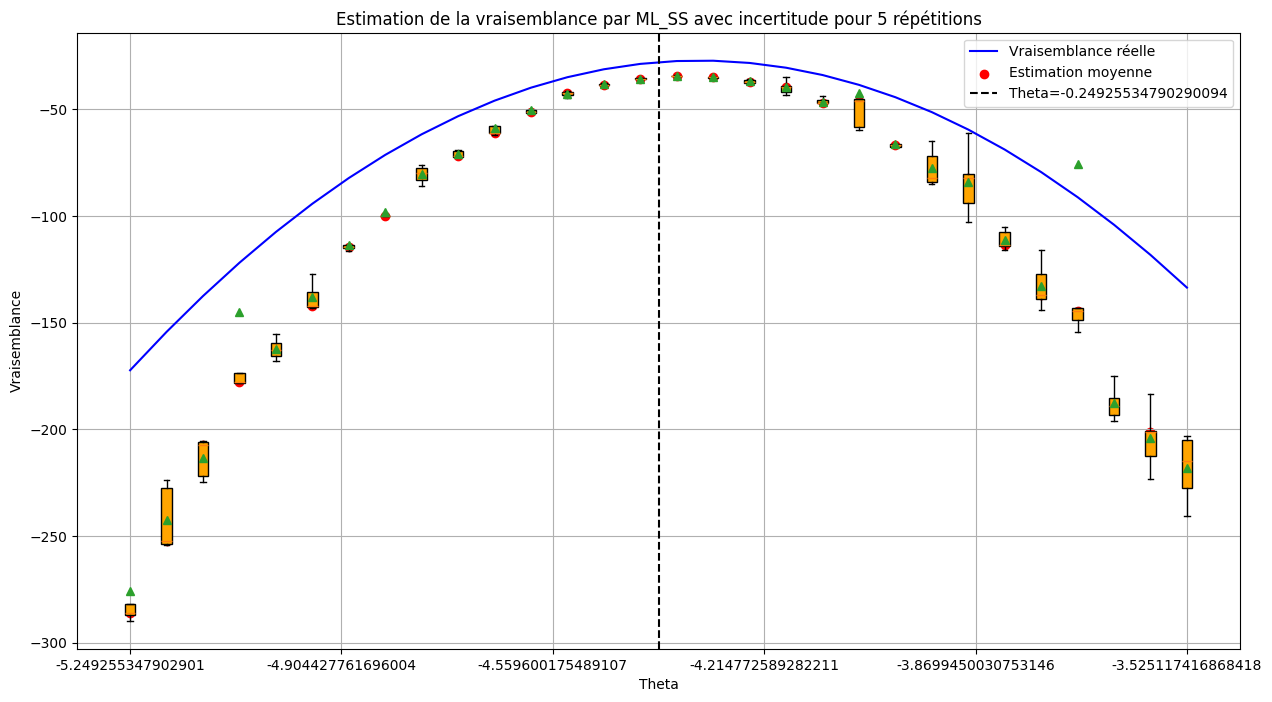

In [8]:
Code.plot_errors_likelihood(r, theta_true, x, noised_A, noised_b, n_simulations,  5, 'ML_SS')

On va désormais s'intéresser à l'estimation de $\nabla_{\theta} l(\theta)$ par notre estimateur ML-SS. L'objectif étant de voir à quel point cet estimateur nous permettra, par la suite, d'approximer $\theta^*$ à l'aide d'une descente de gradient. 

De la même façon, 

In [7]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'ML_SS', k_IWAE)

/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:210: RuntimeWarning: divide by zero encountered in log
  I_0 = np.mean([np.log(weights_array)])
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:212: RuntimeWarning: divide by zero encountered in log
  l_odd = np.log(np.mean(np.exp(np.log(weights_array_odd))))
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:214: RuntimeWarning: divide by zero encountered in log
  l_odd_and_even = np.log(np.mean(np.exp(np.log(weights_array))))
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:213: RuntimeWarning: divide by zero encountered in log
  l_even = np.log(np.mean(np.exp(np.log(weights_array_even))))
/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:1259: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0


Progression:   0%|          | 0/50 [00:08<?, ?it/s]
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:221: RuntimeWarning: invalid value encountered in scalar add
  SS.append(I_0 + (Delta_theta_K/(((1-r)**(K-1))*r)))
Progression:  14%|█▍        | 7/50 [04:22<26:00, 36.29s/it]/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
Progression:  48%|████▊     | 24/50 [15:31<15:23, 35.53s/it]/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:1259: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
Progression:  60%|██████    | 30/50 [19:11<12:07, 36.37s/it]/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:1266: RuntimeWarning: invalid value encountered in scalar subtract
  out[tuple(slice1)] = (f[tuple(slice2)]

ValueError: X must have 2 or fewer dimensions

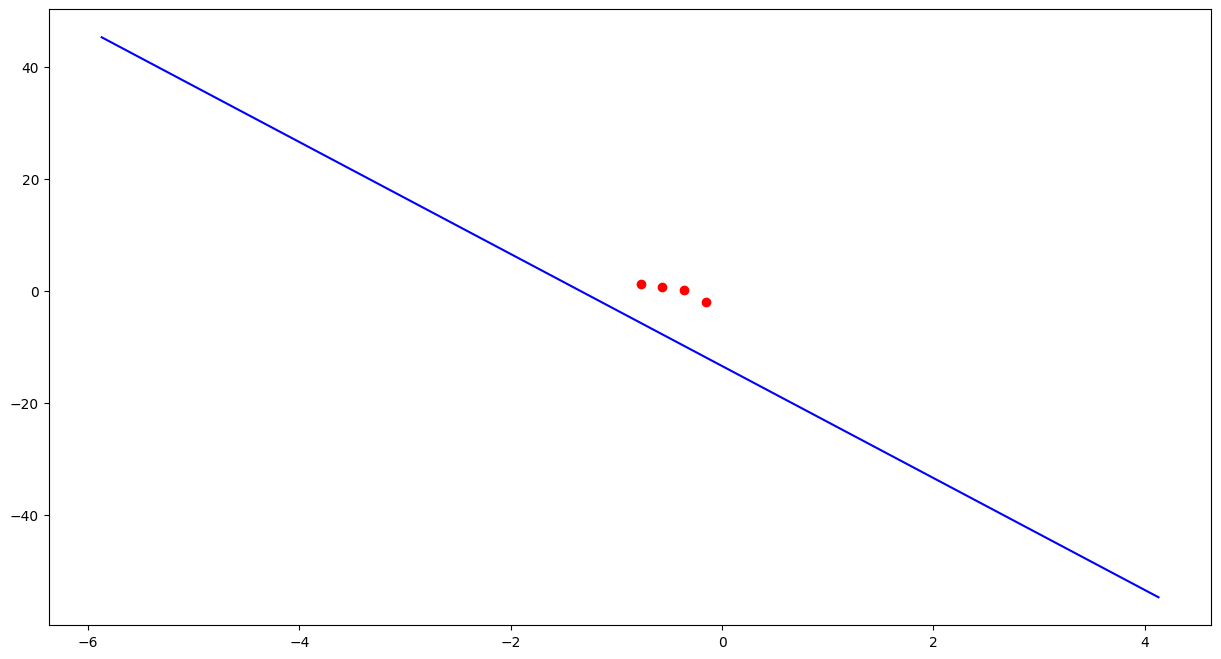

In [10]:
theta_min = theta_true - 5
theta_max = theta_true + 5
step = 0.2
num_points = int((theta_max - theta_min) / step)
theta_values = np.linspace(theta_min, theta_max, num_points)
methode = 'ML_SS'

n_runs = 5

true_gradient_values = [Code.true_grad(x, theta) for theta in theta_values]

estimated_grad = []

# Calcul des vraisemblances estimées et stockage des résultats pour chaque exécution
progress_bar = tqdm(total=len(theta_values), desc='Progression', position=0)
for theta in theta_values:
    grad = []
    for _ in range(n_runs):
        grad.append(Code.grad_ML_SS(r, x, noised_A, noised_b, theta, n_simulations))
    estimated_grad.append(grad)
    time.sleep(0.01)
    progress_bar.update(1)
progress_bar.close()

# Création de la figure
plt.figure(figsize=(15, 8))

# Tracé de la vraisemblance réelle
plt.plot(theta_values, true_gradient_values, color='blue', label='Gradient réel')

# Tracé de la vraisemblance estimée
plt.scatter(theta_values, [np.median(x) for x in estimated_grad], color='red', label='Estimation moyenne')

# Ajout des boxplots
plt.boxplot(estimated_grad, positions=theta_values, widths=0.1, showfliers=False, patch_artist=True, notch=False, showmeans=True, boxprops=dict(facecolor='orange'))

# Ligne verticale pour la valeur de theta_true vrai
plt.axvline(x=theta_true, color='black', linestyle='--', label=f'Theta={theta_true}')

# Mise en forme de la figure
plt.title(f'Estimation du gradient par {methode} avec incertitude pour {n_runs} répétitions')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(theta_values), max(theta_values)+1, 2))


# Affichage de la figure
plt.show()

#### <span style="color:red">  **1.1.2 Estimateur ML-RR**  </span>

In [8]:
n_simulations = 15
r = 0.6

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "ML_RR")

Progression: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]


In [9]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, 15, "ML_RR")

/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:247: RuntimeWarning:

divide by zero encountered in log

/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:251: RuntimeWarning:

divide by zero encountered in log

/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:250: RuntimeWarning:

divide by zero encountered in log



### <span style="color:orange">  **1.2 L'estimateurs SUMO (Stochastically Unbiased Marginalization Objective (SUMO))**  </span>

On pose 
\begin{align*}
\Delta^{\text{SUMO}}_k &:= \hat{\ell}^{(k+2)}(\boldsymbol{\theta}) - \hat{\ell}^{(k+1)}(\boldsymbol{\theta})\\
&:= \log \left( \frac{1}{k+2} \sum_{i=1}^{k+2} w(\boldsymbol{z}_i) \right) - \log \left( \frac{1}{k+1} \sum_{i=1}^{k+1} w(\boldsymbol{z}_i) \right),
\end{align*}

où on rappelle que $w(\boldsymbol{z}) := \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}$.

On applique l'estimateur $RR$ pour construire notre estimateur, que nous appelons $\textbf{SUMO}$ (Stochastically Unbiased Marginalization Objective) qui correspond précisément à l'estimateur de la roulette russe pour $\Delta^{\text{SUMO}}_k$. Ainsi, 
$$
\hat{\ell}^{\text{SUMO}}(\boldsymbol{\theta}) := I_0 + \sum^K_{k=0} \frac{\Delta^{\text{SUMO}}_k}{P(\mathcal{K} \geq k)}
$$
    
où $\mathcal{K} \sim p(\cdot)$ une distrubtion de support dans $\mathbb{N}$

In [ ]:
n_simulations = 15 
r = 0.6

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "SUMO")

Progression: 100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


In [ ]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, 15, 'SUMO')

### <span style="color:orange">  **1.3 L'estimateurs IWAE (Autoencoder Pondéré par l'Importance)**  </span>

Voir l'article séminal sur l'IWAE [ici](https://arxiv.org/pdf/1509.00519.pdf).

L'IWAE utilise cette architecture avec à la fois un **réseau génératif** (paramètre $\boldsymbol{\theta}$) et un **réseau de reconnaissance** (paramètre $\phi$). **La différence est qu'il est entraîné à maximiser une autre borne inférieure** sur $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$. En particulier, nous utilisons la borne inférieure suivante, correspondant à l'estimation de pondération d'importance à $k$ échantillons de la log-vraisemblance :

\begin{align*}
\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi) &= \mathbb{E}_{\boldsymbol{z}_1,\dots,\boldsymbol{z}_k \underset{i.i.d}{\sim} q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}\left[\log \frac{1}{k} \sum_{i=1}^{k} \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}_i)}{q_{\phi}(\boldsymbol{z}_i | \boldsymbol{x})}\right ]
\end{align*}

Ici, $\boldsymbol{z}_1, \dots, \boldsymbol{z}_k$ sont échantillonnés indépendamment du modèle de reconnaissance. Le terme à l'intérieur de la somme correspond aux poids d'importance non normalisés pour la distribution conjointe, que nous noterons $w_i = \frac{p(\boldsymbol{x}, \boldsymbol{z}_i)}{q_{\phi}(\boldsymbol{z}_i | \boldsymbol{x})}$. 

L'optimisation de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ est effectuée conjointement en $\boldsymbol{\theta}$ et $\phi$. 

Il existe deux propriétés de l'IWAE qui nous permettront de le modifier pour produire un estimateur non biaisé :
1. Il est consistant, i.e. lorsque le nombre d'échantillons $k$ augmente, l'espérance de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ converge vers $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$ : 
$$
\log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \lim_{k \rightarrow +\infty} \mathbb{E}[\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)]
$$

2. Il est également croissant en espérance : 
$$
\mathbb{E}[\ell_{\text{IWAE}}^{(k+1)}(\boldsymbol{\theta}, \phi)] \geq \mathbb{E}[\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)]
$$ 

De la même façon que pour les estimateurs précédents, on trace les estimations de l'IWAE sur une plage autour de $\theta^*$

In [ ]:
n_simulations = 15 
k_IWAE = 20
r = 0.6

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true,  n_simulations, k_IWAE, "IWAE")

Progression:   0%|          | 0/60 [00:00<?, ?it/s]

Progression: 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Fixons k_IWAE = 5 et comparons les résultats : 

In [ ]:
k_IWAE = 5

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true,  n_simulations, k_IWAE, "IWAE")

Progression:   0%|          | 0/60 [00:00<?, ?it/s]

Progression: 100%|██████████| 60/60 [00:05<00:00, 11.55it/s]


In [ ]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'IWAE')

### <span style="color:orange">  **1.4 Comparaison entre les différents estimateurs**  </span>

Dans cette partie, nous allons comparer les estimateurs sur un même graphique. 

In [ ]:
Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "all")

Progression: 100%|██████████| 60/60 [02:06<00:00,  2.11s/it]


On fait de même pour le gradient : 

In [ ]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'all')

## <span style="color:green">  **Partie 2. Analyse du Biais et de la Variance des estimateurs**  </span>

Dans cette partie, nous allons comparer les différents estimateurs de la vraisemblance et du gradient en termes de Biais et de Variance (Figure 2 dans la Section de 9 de [l'article](https://proceedings.mlr.press/v130/shi21d.html)).

Le biais d'un estimateur de la vraisemblance $ \ell({\theta})$ est donné par : ${\displaystyle {\text{Biais}}({\hat {\theta }})\equiv \mathbb {E} [{\hat {\theta }}]-\theta }$.

La variance d'un estimateur de la vraisemblance $ \ell({\theta})$ est donné par : $ \text{Var}(\ell(\hat{\theta})) = \mathbb{E}\left[(\ell(\hat{\theta}) - \mathbb{E}[\ell(\hat{\theta})])^2 \right]$

Traçons le Biais au carré de chacun des estimateurs en fonctions de l'espérance du coût computationnel ?? 

In [21]:
Code.plot_bias_variance_likelihood(r, x, theta_true, noised_A, noised_b, 1/5, 1, 2)

In [16]:
Code.plot_bias_likelihood(r, x, theta_true, noised_A, noised_b, 6, 100, 'variance')

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



In [18]:
#Même fonction en faisant varier le nombre de simus :

import plotly.graph_objects as go

def plot_bias_likelihood(r, x, theta_true, noised_A, noised_b, n_simulations_min, n_simulations_max, plot_type = 'bias', k_IWAE = 5): 

    step = 5
    simus = np.arange(n_simulations_min, n_simulations_max, step) #Ici on fait varier le nombre de simulations

    #Calcul de la vraisemblance vraie
    param_true = Code.true_likelihood(x, theta_true)

    if plot_type == 'bias' :

        bias = [], [], [], [] 

        for n_simus in simus:

            n_simus = int(n_simus)

            log_SUMO, log_ML_SS, log_ML_RR, log_IWAE = [], [], [], []

            for i in range(1): #On pourra intégrer le nombre de répétitions aux paramètres si besoin -> moyenne des estimateurs à chaque pas

                log_SUMO.append(Code.log_likelihood_SUMO(r, theta_true, x, noised_A, noised_b, n_simus))

                log_ML_SS.append(Code.log_likelihood_ML_SS(r, theta_true, x, noised_A, noised_b, n_simus))

                log_ML_RR.append(Code.log_likelihood_ML_RR(r, theta_true, x, noised_A, noised_b, n_simus))

                log_IWAE.append(Code.log_likelihood_IWAE(theta_true, x, noised_A, noised_b, k_IWAE, n_simus))

            bias[0].append((np.mean(log_SUMO) - param_true)**2)

            bias[1].append((np.mean(log_ML_SS) - param_true)**2)

            bias[2].append((np.mean(log_ML_RR) - param_true)**2) 

            bias[3].append((np.mean(log_IWAE) - param_true)**2)

        # Créer la figure
        fig = go.Figure()

        # Ajouter les courbes des biais
        fig.add_trace(go.Scatter(x=simus, y=bias[0], mode='lines', name='SUMO', line=dict(color='green')))
        fig.add_trace(go.Scatter(x=simus, y=bias[1], mode='lines', name='ML_SS', line=dict(color='purple')))
        fig.add_trace(go.Scatter(x=simus, y=bias[2], mode='lines', name='ML_RR', line=dict(color='orange')))
        fig.add_trace(go.Scatter(x=simus, y=bias[3], mode='lines', name='IWAE', line=dict(color='yellow')))

        #fig.add_shape(type='line', x0=theta_true, x1=theta_true, y0=min(min(true_gradient_values), min(estimated_grad)), y1=max(max(true_gradient_values), max(estimated_grad)), 
                    #line=dict(color='black', width=2, dash='dash'), name=f'theta={theta_true}')

        # Mise en forme de la figure
        fig.update_layout(
            xaxis=dict(title='Nombre de simulations'),
            yaxis=dict(title="Biais de l'estimateur"),
            title=f'Comparaison du biais des estimateurs de la vraisemblance en fonction du nombre de simulations',
            legend=dict(x=0, y=1, traceorder='normal', font=dict(size=12)),
            showlegend=True
        )

        # Affichage de la figure
        fig.show()

    elif plot_type == 'variance' : #Pas d'actualité on répare d'abord le biais
                
        variance = [], [], [], []

        for n_simus in range(len(simus)):

            n_simus = int(n_simus)

            log_SUMO, log_ML_SS, log_ML_RR, log_IWAE = [], [], [], []

            for i in range(10): #On pourra intégrer le nombre de répétitions aux paramètres si besoin

                log_SUMO.append(log_likelihood_SUMO(r, theta_true, x, noised_A, noised_b, n_simus))

                log_ML_SS.append(log_likelihood_ML_SS(r, theta_true, x, noised_A, noised_b, n_simus))

                log_ML_RR.append(log_likelihood_ML_RR(r, theta_true, x, noised_A, noised_b, n_simus))

                log_IWAE.append(log_likelihood_IWAE(theta_true, x, noised_A, noised_b, k_IWAE, n_simus))
                
            variance[0].append(np.std(log_SUMO) / np.sqrt(10))

            variance[1].append(np.std(log_ML_SS) / np.sqrt(10))

            variance[2].append(np.std(log_ML_RR) / np.sqrt(10))

            variance[3].append(np.std(log_IWAE) / np.sqrt(10))

        # Créer la figure
        fig = go.Figure()

        # Ajouter les courbes des biais
        fig.add_trace(go.Scatter(x=simus, y=variance[0], mode='lines', name='SUMO', line=dict(color='green')))
        fig.add_trace(go.Scatter(x=simus, y=variance[1], mode='lines', name='ML_SS', line=dict(color='purple')))
        fig.add_trace(go.Scatter(x=simus, y=variance[2], mode='lines', name='ML_RR', line=dict(color='orange')))
        fig.add_trace(go.Scatter(x=simus, y=variance[3], mode='lines', name='IWAE', line=dict(color='yellow')))

        #fig.add_shape(type='line', x0=theta_true, x1=theta_true, y0=min(min(true_gradient_values), min(estimated_grad)), y1=max(max(true_gradient_values), max(estimated_grad)), 
                    #line=dict(color='black', width=2, dash='dash'), name=f'theta={theta_true}')

        # Mise en forme de la figure
        fig.update_layout(
            xaxis=dict(title='Nombre de simulations'),
            yaxis=dict(title="Variance de l'estimateur"),
            title=f'Comparaison de la variance des estimateurs de la vraisemblance en fonction du nombre de simulations',
            legend=dict(x=0, y=1, traceorder='normal', font=dict(size=12)),
            showlegend=True
        )

        # Affichage de la figure
        fig.show()
    
    return


In [19]:
plot_bias_likelihood(r, x, theta_true, noised_A, noised_b, 1, 100)